# Handling overscan, trimming, and bias subtraction


## Introduction

The bias in a CCD camera is a DC offset applied to all pixels so that when the
voltage in each pixel is converted to a number the number will always be
positive. In an ideal CCD the bias would be the same for every pixel and not
change over time. In practice, the bias is slightly different for each pixel,
and can vary by a count or two from night to night or during a night.

A bias *image* is a picture taken with the shutter closed and zero exposure
time; think about it as a command to the camera to do whatever it usually does
to prepare the camera's electronics to take an image and then immediately read
out the CCD as though you had taken a picture.

## Sample bias images

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/106/files#diff-3dd85a391bd98db8392ba77440bd56b2R37){:target="_blank"}

The images below are a single bias frame and an average 100 bias frames from an
[Andor Apogee Aspen CG16M](http://www.andor.com/pdfs/specifications/Apogee_Aspen_CG16M_Specifications.pdf), a low-end 4k × 4k CCD with a
[Kodak KAF-16803 sensor chip](http://www.onsemi.com/pub/Collateral/KAF-16803-D.PDF). That model camera has a typical bias level
around 1000 and read noise around 10 $e^-$, though the precise value varies from
camera to camera and with temperature.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

In [4]:
from astropy.nddata import CCDData
from astropy.visualization import hist

import numpy as np

from convenience_functions import show_image

download_base_url = 'http://physics.mnstate.edu/craig/ccd-guide/'

In [5]:
one_bias = CCDData.read(download_base_url + 'dark-test-0100bias.fit.gz', unit='adu')
one_hundred_bias = CCDData.read(download_base_url + 'master_bias.fit.gz', unit='adu')

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


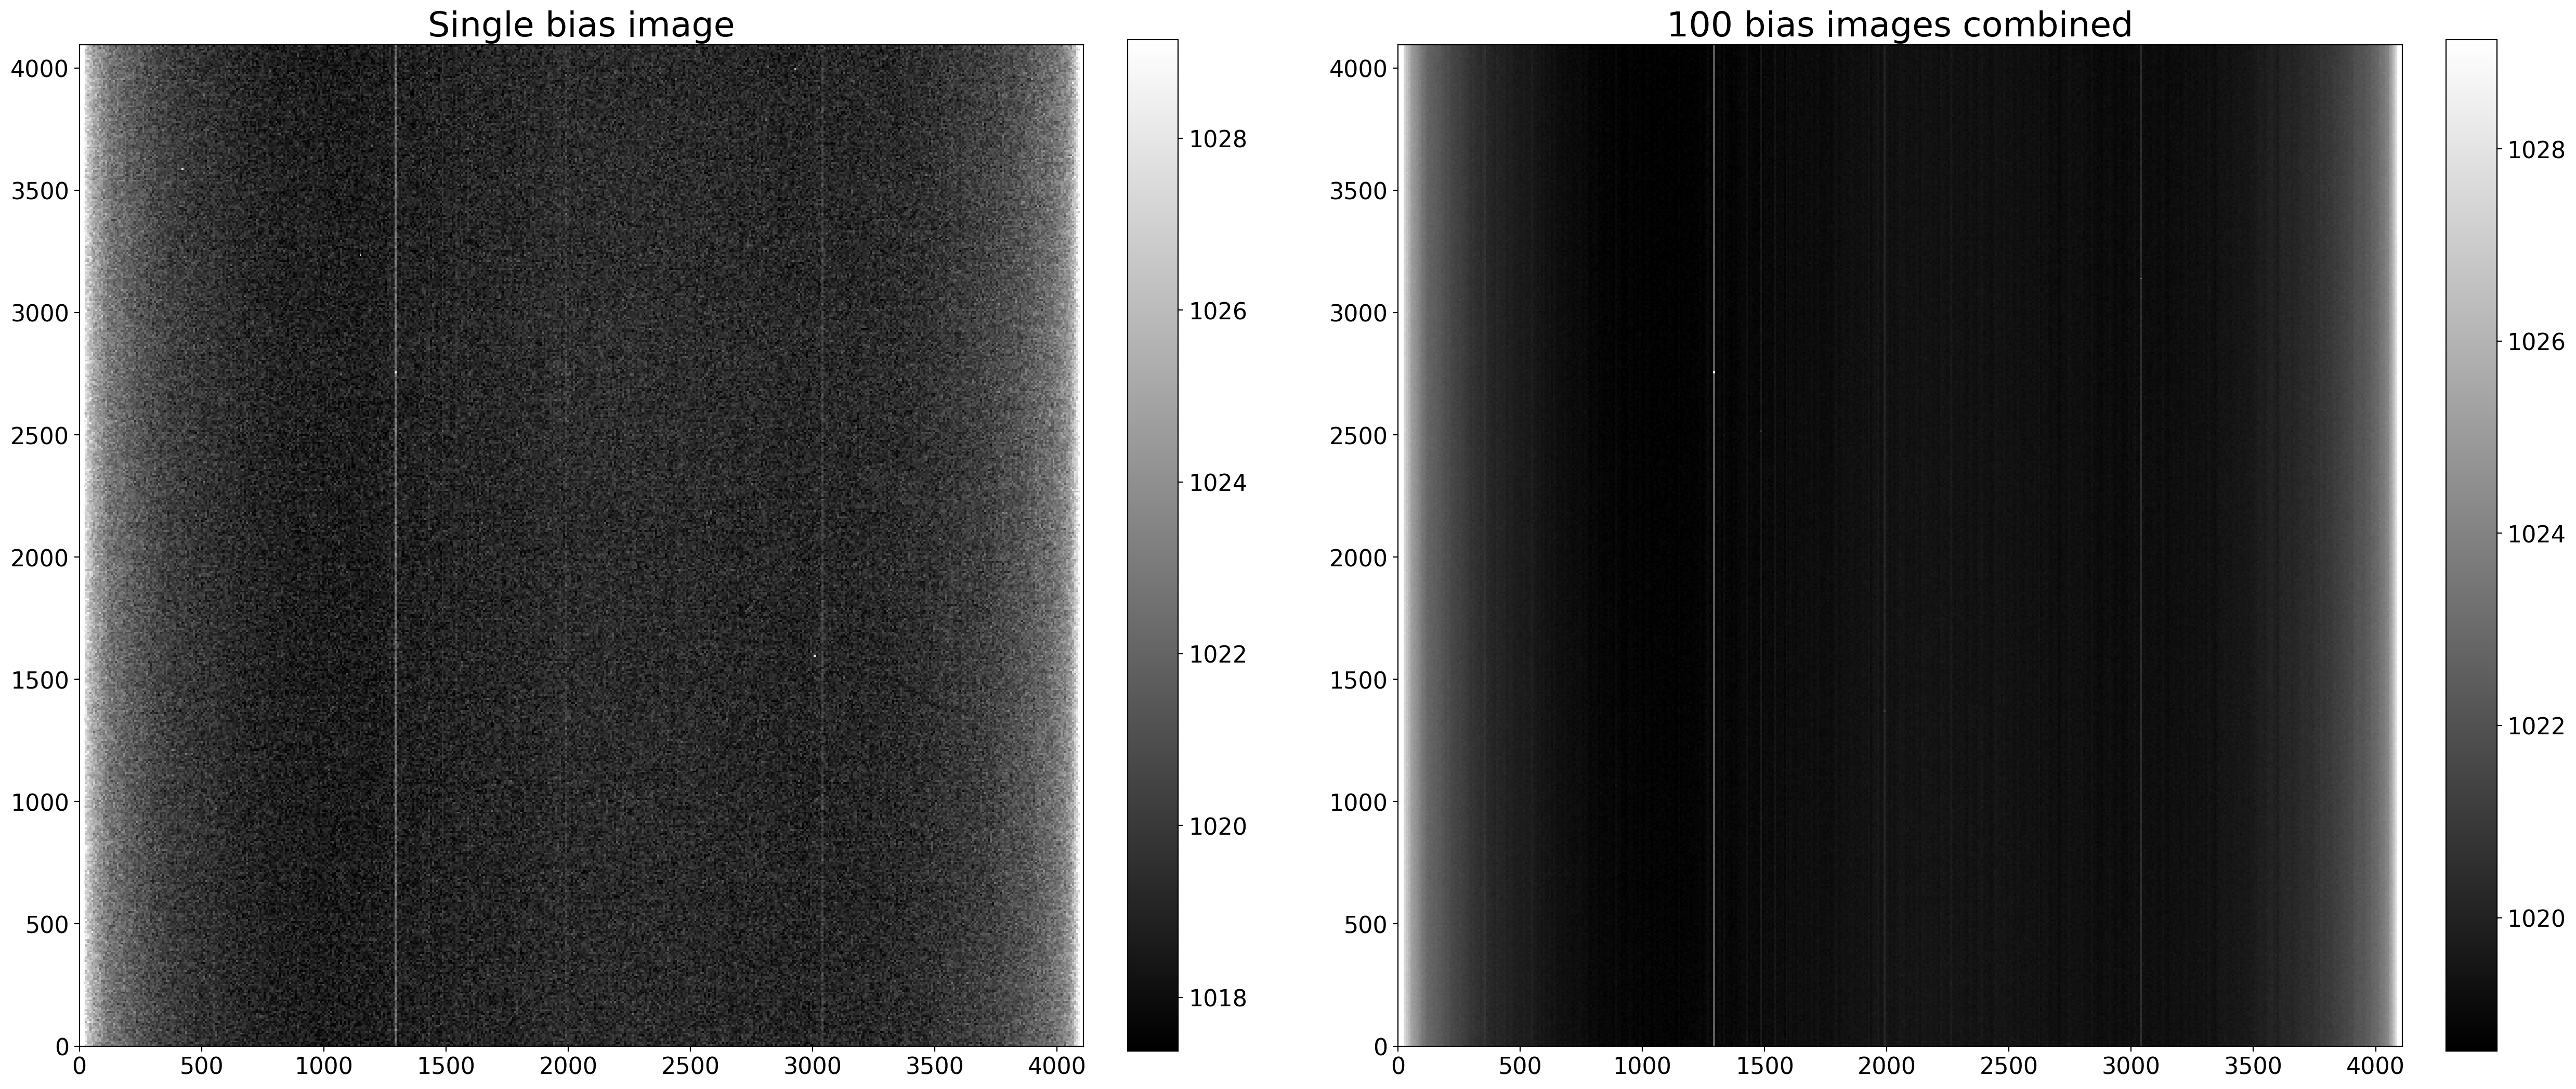

In [6]:
fig, (ax_1_bias, ax_avg_bias) = plt.subplots(1, 2, figsize=(30, 15))

show_image(one_bias.data, cmap='gray', ax=ax_1_bias, fig=fig, input_ratio=8)
ax_1_bias.set_title('Single bias image')
show_image(one_hundred_bias.data, cmap='gray', ax=ax_avg_bias, fig=fig, input_ratio=8)
ax_avg_bias.set_title('100 bias images combined');

### Note a few things

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/106/files#diff-3dd85a391bd98db8392ba77440bd56b2R122){:target="_blank"}

+ The bias level in this specific camera is about 1023 (the mid-range of the
colorbar).
+ The image is brighter on the left and right edges. This "amplifier glow" is
frequently present and caused by the CCD electronics (photosensors with an
applied voltage are LEDs).
+ There are several vertical lines; these are columns for which the bias level
is consistently higher.
+ There is noticeable "static" in the images; that is read noise.
+ None of the variations are particularly large.
+ Combining several bias images vastly reduces the read noise. This example is a
little unrealistic in that 100 bias images were combined but does illustrate the
idea that combining images reduces noise.

## Impact of combining images on noise

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/106/files#diff-3dd85a391bd98db8392ba77440bd56b2R142){:target="_blank"}

As discussed at length in the [notebook on combination](01-06-Image-combination.html), the reason for
taking and combining several calibration images is to reduce the noise if the
images used for calibration. The difference between a single image and a
combination of images is apparent in the images above. Another way to see the
impact of combining images in the histogram of pixel values. Notice that the
distribution of values is much narrower for the combined image than for a single
bias. Pixels near the edges, where the amplifier glow is large, are binned
separately from the rest of the pixels to emphasize the uniformity of the chip
away from the glow.

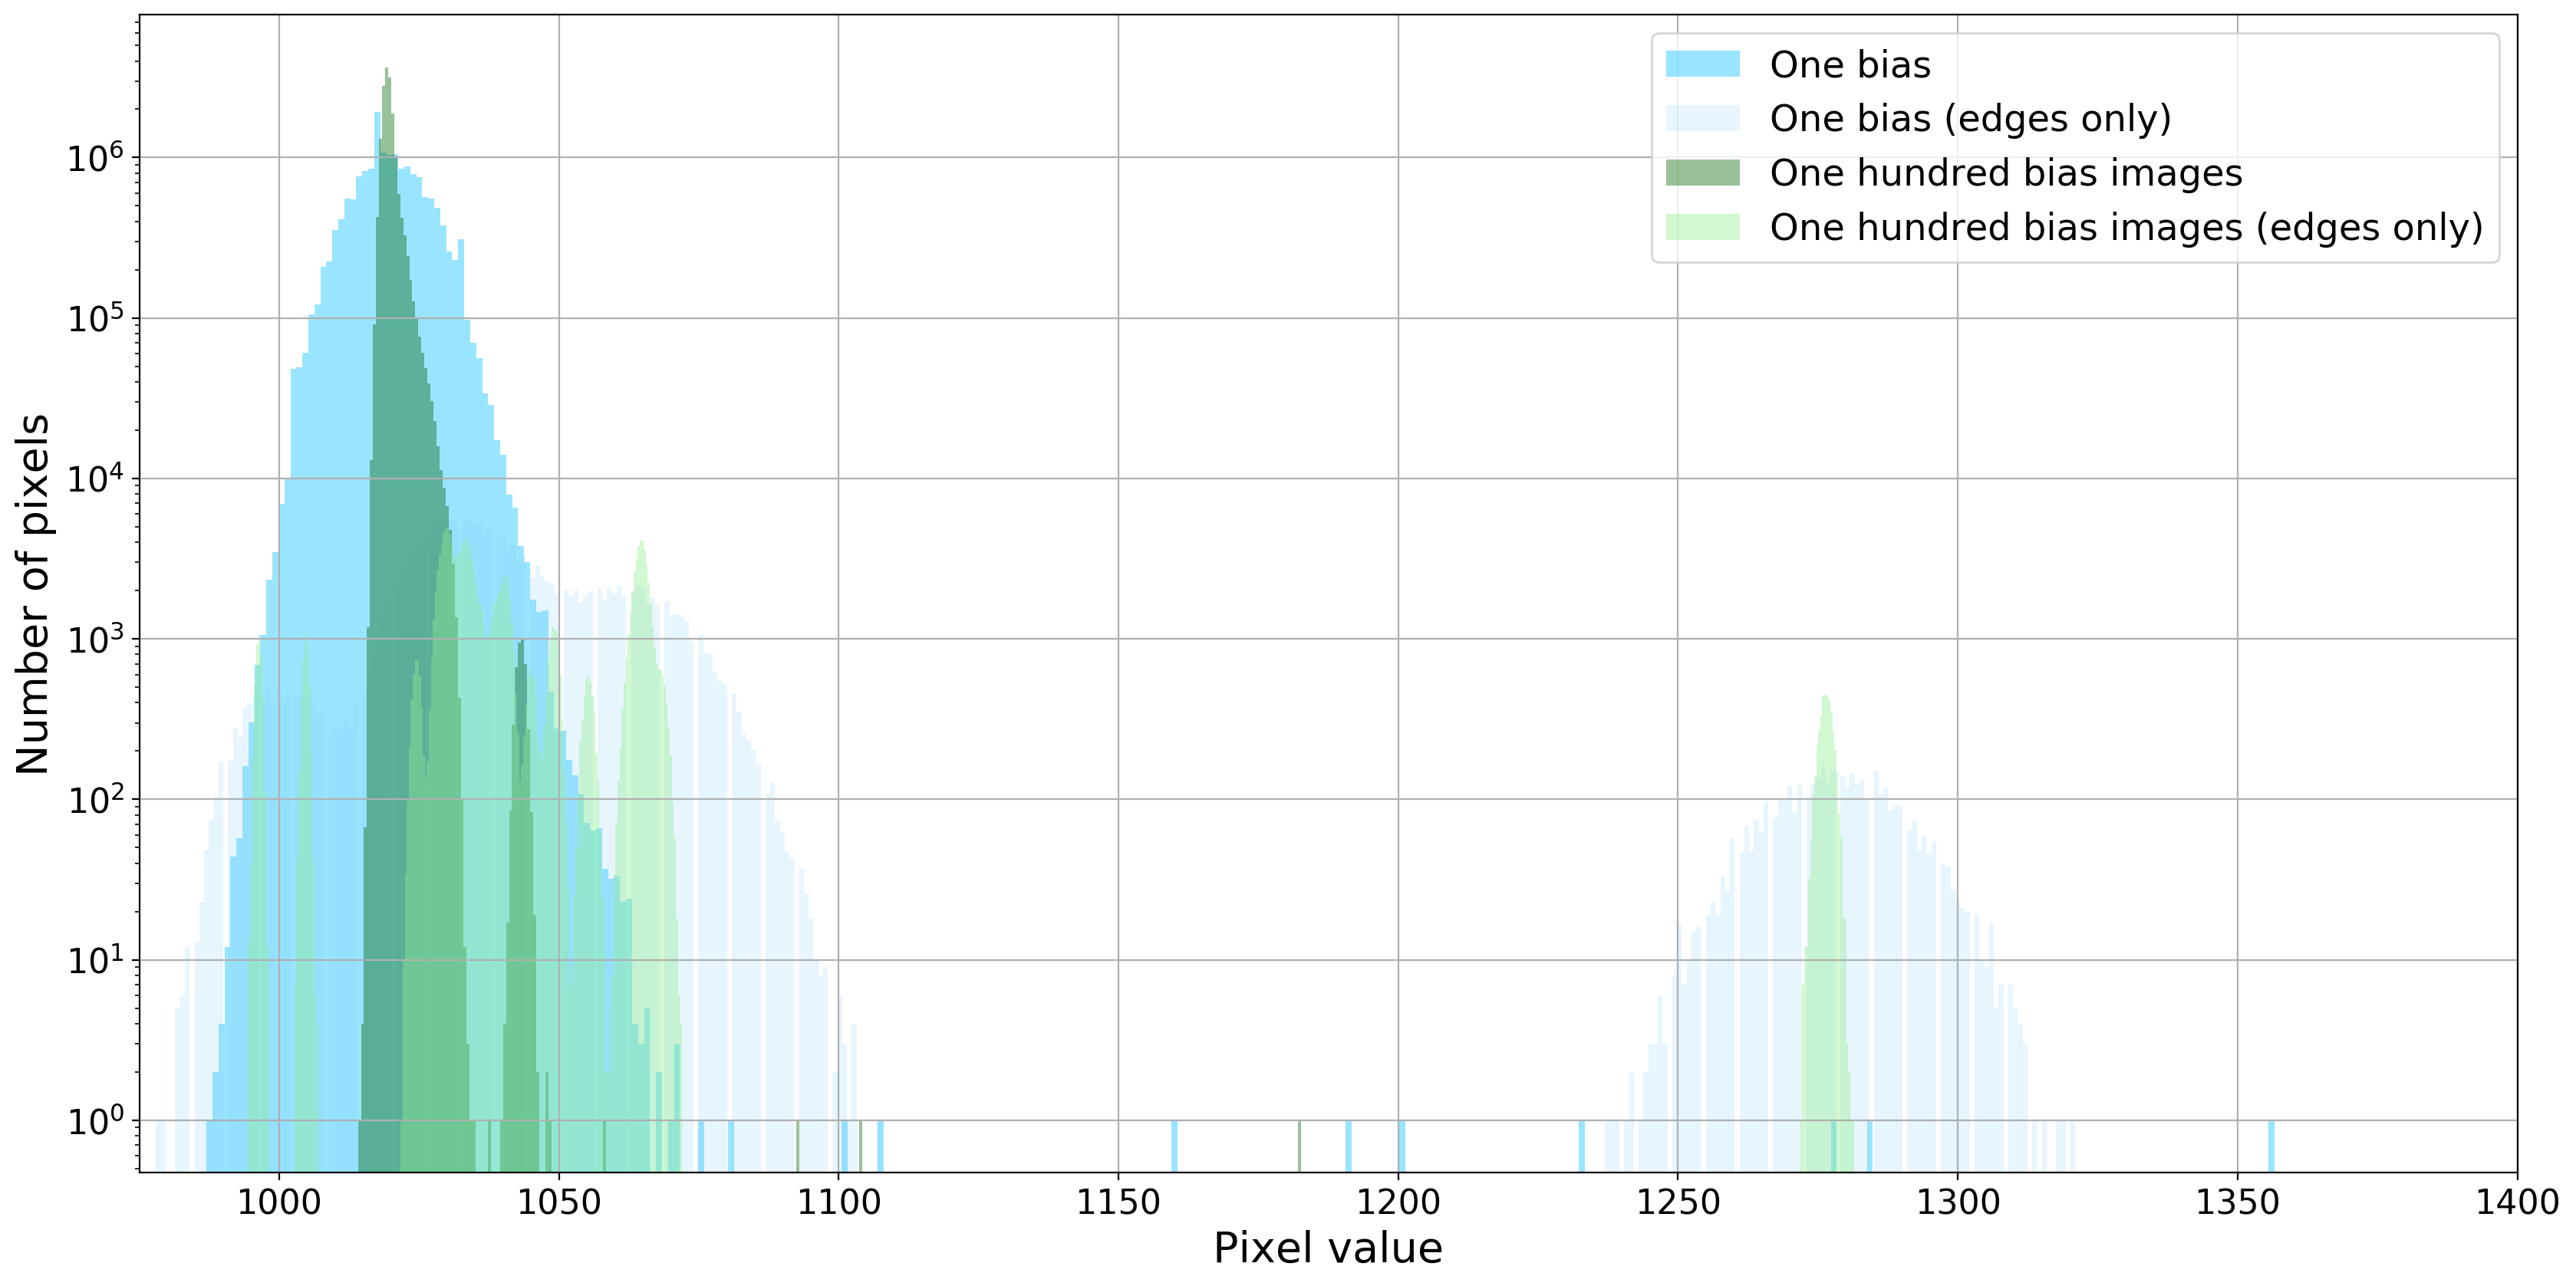

In [7]:
plt.figure(figsize=(20, 10))
hist(one_bias.data[:, 15:-30].flatten(), bins=800, alpha=0.4, label='One bias', color='deepskyblue')
hist(np.concatenate((one_bias.data[:, :15].flatten(), one_bias.data[:, -30:].flatten())), bins=400, alpha=0.2, label='One bias (edges only)', color='lightskyblue')
#hist(, bins=800, alpha=0.2, label='One bias (edges only)', color='darkblue')
hist(one_hundred_bias.data[:, 15:-30].flatten(), bins=800, alpha=0.4, label='One hundred bias images', color='darkgreen')
hist(np.concatenate((one_hundred_bias.data[:, :15].flatten(), one_hundred_bias.data[:, -30:].flatten())), bins=800, alpha=0.4, label='One hundred bias images (edges only)', color='lightgreen')

#hist(one_hundred_bias.data[:, :15].flatten(), bins=800, alpha=0.4, label='One hundred bias images', color='darkgreen')

plt.grid()
plt.xlim(975, 1400)
plt.legend()
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.semilogy();

## Bias calibration  overview

The progression here is to "calibrate" the bias images by subtracting overscan,
if desired, trim the overscan from the bias images if it is present, and combine
all of the bias images to make a "combined" bias (another common term for these
images is "master" bias and occasionally "super" bias).